# Evaluating

The final stage, evaluating the model. We consider the test set composed by $200$ classes, each class with $50$ images. We consider two metrics rank-1 and rank-5. Rank-1 is the accuracy. Beyond these metrics, we also consider the error rate, calculated as $ER = 1 - rank1$. This metrics measures how our model generalizes the main characteristics of the dataset.

## Importing libraries

In [1]:
from config import tiny_imagenet_config as config
from compvis.preprocessing import ImageToArrayPreprocessor
from compvis.preprocessing import SimplePreprocessor
from compvis.preprocessing import MeanPreprocessor
from compvis.utils.ranked import rank5_accuracy
from compvis.io import HDF5DatasetGenerator
from tensorflow.keras.models import load_model
import json
import numpy as np
import matplotlib.pyplot as plt

## Visualizing the training results

At the end of the training, we have a json file with all history of the training. We consider this file to plot the results of accuracy and loss function, for the training and validation set.

In [2]:
results = json.loads(open(config.JSON_PATH).read()) # reading the json file

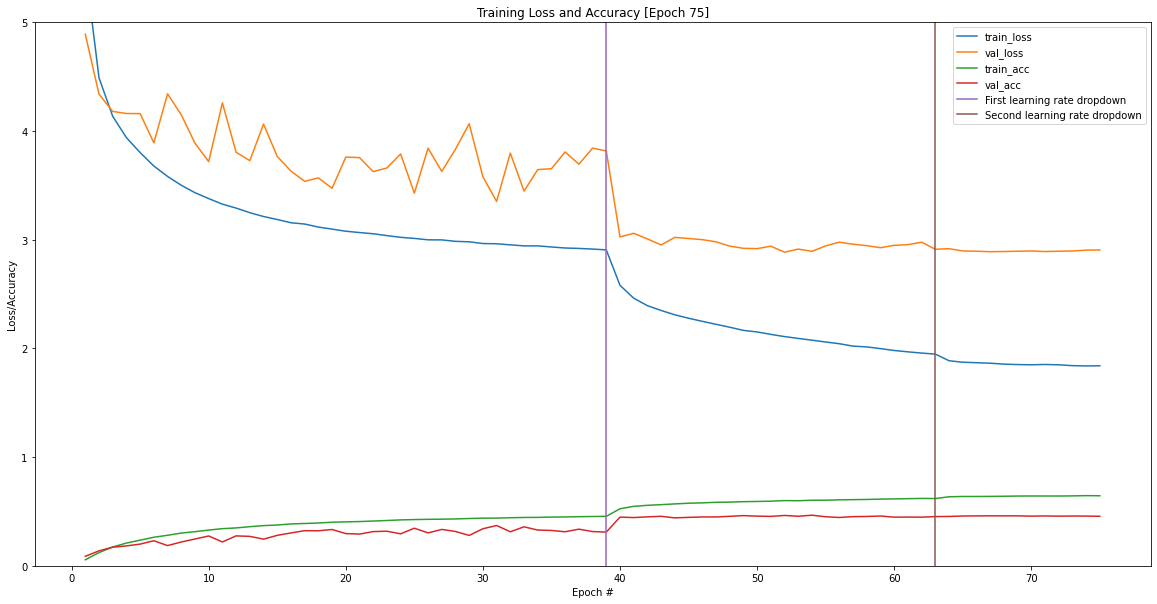

In [25]:
N = np.arange(1, len(results["loss"])+1) # range of epochs
plt.figure(figsize=(20,10))
plt.plot(N, results["loss"], label="train_loss")
plt.plot(N, results["val_loss"], label="val_loss")
plt.plot(N, results["accuracy"], label="train_acc")
plt.plot(N, results["val_accuracy"], label="val_acc")
plt.ylim([0.0, 5])
plt.plot([40-1,40-1], plt.ylim(), label='First learning rate dropdown')
plt.title("Training Loss and Accuracy [Epoch {}]".format(len(results["loss"])))
plt.plot([64-1,64-1], plt.ylim(), label='Second learning rate dropdown')
plt.title("Training Loss and Accuracy [Epoch {}]".format(len(results["loss"])))
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

As we can see, the model does not have a great accuracy, around $0.60$ for the test set and $0.49$ for the validation set. We also observe the difficult to stabilize the loss functions. During the first train step with learning rate of $1e-3$, the validation loss oscillates and goes far from the training loss. During the second step, with learning rate of $1e-4$, the validation loss function decrease a bit, but the gap between is always high. At the third step, with learning rate of $1e-5$, the loss functions tends the to the stagnation, there's no more learning.

## Loading and preprocessing the test set

**RGB mean file**

In [4]:
# load the RGB means for the training set
means = json.loads(open(config.DATASET_MEAN).read())

In [5]:
means

{'R': 122.46798762478299, 'G': 114.2399103000217, 'B': 101.34937106933593}

**Data preprocessors**

In [6]:
sp = SimplePreprocessor(64, 64)
mp = MeanPreprocessor(means["R"], means["G"], means["B"])
iap = ImageToArrayPreprocessor()

**Generating the test set**

In [7]:
testGen = HDF5DatasetGenerator(config.TEST_HDF5, 64,
                               preprocessors=[sp, mp, iap], 
                               classes=config.NUM_CLASSES)

## Loading the model

In [8]:
model = load_model(config.MODEL_PATH)

**Predicting on the test set**

In [9]:
predictions = model.predict(testGen.generator(), 
                            steps=testGen.numImages // 64,
                            max_queue_size=64 * 2)

## Scores

The rank1 is calculated as the accuracy, with the prediction is true, it increases the accuracy value. The rank5 is a bit different, in this case, we consider the top five predictions, if the class is on the top five, the value increases.

In [10]:
# compute the rank-1 and rank-5 accuracies
(rank1, rank5) = rank5_accuracy(predictions, testGen.db["labels"])

In [11]:
print("[INFO] rank-1: {:.2f}%".format(rank1 * 100))
print("[INFO] rank-5: {:.2f}%".format(rank5 * 100))
print("[INFO] error rate: {:.4f}".format(1-rank1))

[INFO] rank-1: 44.61%
[INFO] rank-5: 70.95%
[INFO] error rate: 0.5539


## Conclusions

We've trained the GoogLeNet from scratch on the Tiny ImageNet dataset. The error rate was $0.55$, that's a good result, the model achieved a good generalization, but it's not on the top five models. This results can be improved with other models for this dataset challenge.